In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize  import curve_fit
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine

# Inputs and reading in of all the files

In [2]:
# Frequently changing 
filename= 'P12_replicate2_aj'
tmt= pd.read_csv('plim12_replicate2.csv')

wide_isolation_use= 'no'
max_intensity_peptide_only_use= 'no'
choice_value_input= 'm'

extra_time=0
time_array=np.array([0, 175, 301, 424, 677, 927, 1334, 2109]) 
Dilution_half_life_hrs= 12.0
Cfactor= 100



In [3]:
# Table for number of nitrogen per amino acid
nitrogen_number= pd.read_excel('../../E.coli resources/amino_acid.xlsx')

# # # Entry to gene names and subcellular location for protein ids 
tmt5_location= pd.read_csv('../../E.coli resources/MG1655_gene_names_location.csv')

# Commonly used functions

In [4]:
def header_splitter(x):
    if(x.count('|')==2):
         y=x.split('|')[1]  # takes only number as an identifier
    elif (x.count('|')==1):
         y=x.split('|')[0] 
    else:
         y=x
    return y

def sub_cellular(choice, df): 
    if choice =='o': 
        df_return = df[(df['Subcellular location [CC] 1'].str.contains('outer')==True) & (df['Subcellular location [CC] 1'].str.contains('membrane')==True) ]
    elif choice =='p': 
        df_return= df[df['Subcellular location [CC] 1'].str.contains('Periplasm')==True]
    elif choice=='c': 
        df_return= df[df['Subcellular location [CC] 1'].str.contains('Cytoplasm')==True]
    elif choice=='m': 
        df_return= df[df['Subcellular location [CC] 1'].str.contains('membrane')==True]
    elif choice=='i': 
        df_return = df[(df['Subcellular location [CC] 1'].str.contains('outer')==False) & (df['Subcellular location [CC] 1'].str.contains('membrane')==True) ]
    return (df_return)



def normalized_array_for_plotting(dilution_half_life_h, active_degradation_rate_per_min, nitrogen_number): 
    D=np.log(2)/ dilution_half_life_h/60
    Dt= D+active_degradation_rate_per_min
    n=nitrogen_number
    term1= Dt
    term2= n*Cfactor*D
    constant= term1-term2
    final= (term1*np.exp(-term2*time_array)-term2*np.exp(-term1*time_array))/constant
    sum_final=final.sum()
    final1= final/sum_final
    return final1


def cosine_distance_calculator(x): 
     return (1-cosine(x, normalized_array_for_plotting(Dilution_half_life_hrs, 0, 12)))


def vector_sum(x): 
    i=0 
    array_new= []
    while i<(len(x)-1): 
        array_new.append(np.sum(x[i:i+8])) 
        i=i+8
    #print array_new
    return np.repeat(array_new,8)

def degradation(X, a):
    kd= np.log(2)/ (Dilution_half_life_hrs*60)
    t,n= X
    c= Cfactor
    vector1= (a*np.exp(-n*t*c*kd)- n*c*kd*np.exp(-a*t))
    vector2= vector_sum(vector1)
    vector3= vector1/vector2
    return vector3

#### Initial Preprocessing

In [5]:

tmt1= tmt[tmt['Parsimony'].isnull()==False]

tmt2= tmt1[tmt1['Protein ID'].str.contains("#")==False]

tmt3= tmt2[tmt2['Protein ID'].str.contains('contaminant')==False]
 

# For peptides that are chosen again and again chosse the one with the max signal 

tmt3['sum_signal']= tmt3['AYnmin1Pmin1 Sn']+tmt3['BYnmin1P0 Sn']+tmt3['CYnmin1Pplus1 Sn']+tmt3['DYnmin1Pplus2 Sn']+tmt3['EYnmin1Pplus3 Sn']+tmt3['FYnmin1Pplus4 Sn']+tmt3['GYnmin1Pplus5 Sn']+tmt3['HYnmin1Pplus6 Sn']+tmt3['IYnmin1Pplus7 Sn']+tmt3['JYnmin1Pplus8 Sn']+tmt3['KYnmin1Pplus9 Sn']+tmt3['LYnmin1Pplus10 Sn']
tmt4= tmt3[tmt3['sum_signal']>40]

tmt4['sum_ratios']= tmt4['ratios1']+tmt4['ratios2']+tmt4['ratios3']+tmt4['ratios4']+tmt4['ratios5']+tmt4['ratios6']+tmt4['ratios7']+tmt4['ratios8']
tmt5= tmt4[tmt4['sum_ratios']!=0]

# Oxidised methionines 
tmt6=tmt5[tmt5['Peptide'].str.contains('\*')==False]


# Missed cleaved peptides are also thrown out
tmt6['strip_peptides']= tmt6['Peptide'].map(lambda x: x.split('.')[1])
tmt6['strip_peptides2']= tmt6['strip_peptides'].map(lambda x: x[:-1])
tmt6['Peptide_length']= tmt6['strip_peptides'].map(lambda x: len(x))
tmt7= tmt6[tmt6['strip_peptides2'].str.contains('K')==False]
tmt8= tmt7[tmt7['strip_peptides2'].str.contains('R')==False]

# check which all charges are present 
tmt9= tmt8[tmt8['z']==2]


# filtering based on the monisotopic peak masses 
tmt9['theoretical_mass_Da']=tmt9['z']*tmt9['Theo m/z']
tmt9['expected_da_less']= tmt9['theoretical_mass_Da']-0.1
tmt9['expected_da_more']= tmt9['theoretical_mass_Da']+0.1

tmt9['Isolation_mass_Da']= tmt9['z']*tmt9['Isolation m/z']
tmt10= tmt9[(tmt9.Isolation_mass_Da>tmt9.expected_da_less)&(tmt9['Isolation_mass_Da']<=tmt9['expected_da_more'])]



# only get that particular instance of a peptide that has maximum signal 
if max_intensity_peptide_only_use=='yes': 
    df_final= tmt10.sort_values(by=['Peptide','sum_signal'],ascending=False).drop_duplicates(keep='first',subset=['Peptide'])
else: 
    df_final= tmt10


    
print (tmt.shape, tmt1.shape, tmt2.shape, tmt3.shape, tmt4.shape, tmt5.shape , tmt6.shape, tmt7.shape, tmt8.shape,tmt9.shape, tmt10.shape, df_final.shape)    
print ('No of proteins %d' %(df_final.groupby(['Protein ID']).ngroups)) 

C:\Users\gupta\AppData\Local\Temp\ipykernel_588\2318571863.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmt3['sum_signal']= tmt3['AYnmin1Pmin1 Sn']+tmt3['BYnmin1P0 Sn']+tmt3['CYnmin1Pplus1 Sn']+tmt3['DYnmin1Pplus2 Sn']+tmt3['EYnmin1Pplus3 Sn']+tmt3['FYnmin1Pplus4 Sn']+tmt3['GYnmin1Pplus5 Sn']+tmt3['HYnmin1Pplus6 Sn']+tmt3['IYnmin1Pplus7 Sn']+tmt3['JYnmin1Pplus8 Sn']+tmt3['KYnmin1Pplus9 Sn']+tmt3['LYnmin1Pplus10 Sn']
C:\Users\gupta\AppData\Local\Temp\ipykernel_588\2318571863.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

(127359, 244) (41233, 244) (41200, 244) (41040, 245) (40200, 246) (40200, 246) (34482, 249) (34226, 249) (33210, 249) (33210, 253) (30344, 253) (30344, 253)
No of proteins 2504


C:\Users\gupta\AppData\Local\Temp\ipykernel_588\2318571863.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmt6['Peptide_length']= tmt6['strip_peptides'].map(lambda x: len(x))


In [6]:
# Count the number of nitrogen in a peptide
df_final['Nitrogens']=0
for index,ni in nitrogen_number[['Amino acid','Nitrogen']].iterrows():
    df_final['Nitrogens'] += df_final['strip_peptides'].str.count(ni['Amino acid'])*ni['Nitrogen']


C:\Users\gupta\AppData\Local\Temp\ipykernel_588\3572796094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Nitrogens']=0
C:\Users\gupta\AppData\Local\Temp\ipykernel_588\3572796094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Nitrogens'] += df_final['strip_peptides'].str.count(ni['Amino acid'])*ni['Nitrogen']


In [7]:
df_final1 = df_final[['Protein ID', 'Peptide','ScanF','ratios1', 'ratios2', 'ratios3', 'ratios4','ratios5', 'ratios6', 'ratios7','ratios8', 'Nitrogens', 'sum_signal']].reset_index()

if wide_isolation_use=='no': 
    array= np.repeat(1,8)
    number1= array[0]
    number2= array[1]
    number3= array[2]
    number4= array[3]
    number5= array[4]
    number6= array[5]
    number7= array[6]
    number8= array[7]
else: 
    array= wide_isolation
    number1= array['0'][0]
    number2= array['0'][1]
    number3= array['0'][2]
    number4= array['0'][3]
    number5= array['0'][4]
    number6= array['0'][5]
    number7= array['0'][6]
    number8= array['0'][7]


df_final1['0_med']= df_final1['ratios1'].astype(float)/ number1
df_final1['1_med']= df_final1['ratios2'].astype(float)/ number2
df_final1['2_med']= df_final1['ratios3'].astype(float)/ number3
df_final1['3_med']= df_final1['ratios4'].astype(float)/ number4
df_final1['4_med']= df_final1['ratios5'].astype(float)/ number5
df_final1['5_med']= df_final1['ratios6'].astype(float)/ number6
df_final1['6_med']= df_final1['ratios7'].astype(float)/ number7
df_final1['7_med']= df_final1['ratios8'].astype(float)/ number8

df_final1['sum_med']= df_final1['0_med'].astype(float)+ df_final1['1_med']+df_final1['2_med']+df_final1['3_med']+df_final1['4_med']+df_final1['5_med']+df_final1['6_med']+df_final1['7_med']
df_final1['0_med_ave']= df_final1['0_med'].astype(float)/ df_final1['sum_med']
df_final1['1_med_ave']= df_final1['1_med'].astype(float)/ df_final1['sum_med']
df_final1['2_med_ave']= df_final1['2_med'].astype(float)/ df_final1['sum_med']
df_final1['3_med_ave']= df_final1['3_med'].astype(float)/ df_final1['sum_med']
df_final1['4_med_ave']= df_final1['4_med'].astype(float)/ df_final1['sum_med']
df_final1['5_med_ave']= df_final1['5_med'].astype(float)/ df_final1['sum_med']
df_final1['6_med_ave']= df_final1['6_med'].astype(float)/ df_final1['sum_med']
df_final1['7_med_ave']= df_final1['7_med'].astype(float)/ df_final1['sum_med']


df_final1['Entry']= df_final1['Protein ID'].apply(header_splitter)
df_final2= df_final1.merge(tmt5_location[['Entry', 'Subcellular location [CC] 1', 'membrane_confirmation']], on='Entry', how='left')
df_final2.head()

,index,Protein ID,Peptide,ScanF,ratios1,ratios2,ratios3,ratios4,ratios5,ratios6,...,1_med_ave,2_med_ave,3_med_ave,4_med_ave,5_med_ave,6_med_ave,7_med_ave,Entry,Subcellular location [CC] 1,membrane_confirmation
0,8,sp|P0ABS1|DKSA_ECOLI,-.MQEGQNR.K,573,0.29014,0.23561,0.19184,0.147750,0.054390,0.049240,...,0.235609,0.191839,0.147749,0.054390,0.049240,0.030976,0.000059,P0ABS1,Cytoplasm,False
1,11,sp|P39406|RSMC_ECOLI,R.QMGDNAR.F,616,0.24242,0.22165,0.13223,0.161190,0.072329,0.083222,...,0.221651,0.132230,0.161190,0.072329,0.083222,0.070319,0.016637,P39406,Cytoplasm,False
2,20,sp|P39285|MSCM_ECOLI,R.NQLNSQR.Q,787,0.25875,0.20094,0.16914,0.109230,0.076581,0.086412,...,0.200940,0.169140,0.109230,0.076581,0.086412,0.062408,0.036537,P39285,Cell inner membrane,True
3,23,sp|P60716|LIPA_ECOLI,R.HHLPVQR.Y,901,0.46929,0.23638,0.14028,0.087661,0.043524,0.022708,...,0.236381,0.140281,0.087661,0.043524,0.022708,0.000074,0.000078,P60716,Cytoplasm.,False
4,26,sp|P0A6Z1|HSCA_ECOLI,R.AQDFTTFK.D,10005,0.28456,0.22778,0.18658,0.141770,0.079025,0.048670,...,0.227780,0.186580,0.141770,0.079025,0.048670,0.025045,0.006569,P0A6Z1,NaN,False


# Look at the data

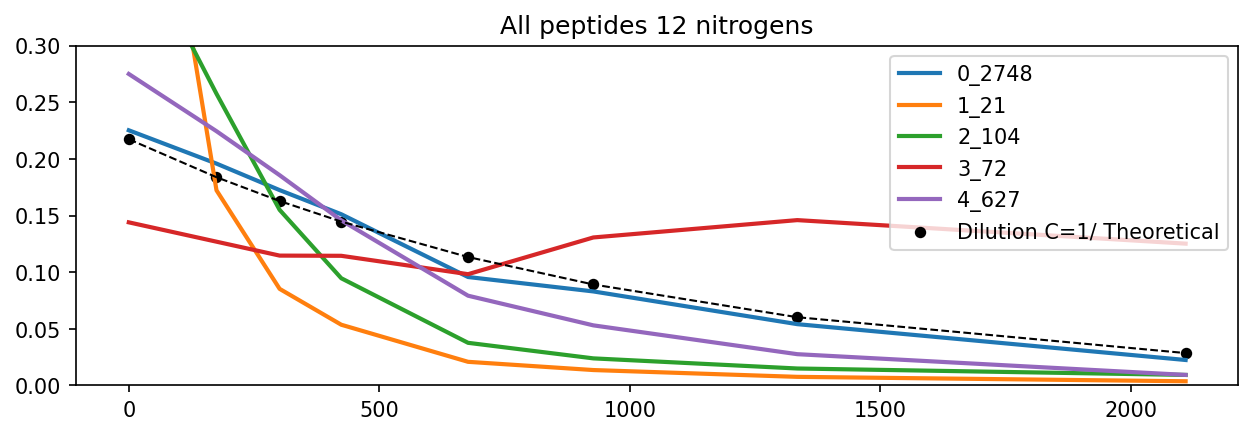

In [8]:
# Kmeans clustering of the data 
# Kmeans clustering of the membrane proteins

plt.figure(figsize=(10,3),dpi=150)

nitrogen_test= 12
temporary=df_final2[df_final2['Nitrogens']==nitrogen_test]

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']]
kmeans= KMeans(n_clusters=5, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []
i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    cluster_number.append(len(kmeans.labels_[kmeans.labels_==i]))
    
    i=i+1
    
plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution C=1/ Theoretical')
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.3])
plt.title('All peptides %d nitrogens'%(nitrogen_test))
plt.legend()
plt.show()

# median all... median membrane and cytoplasm and periplasm 

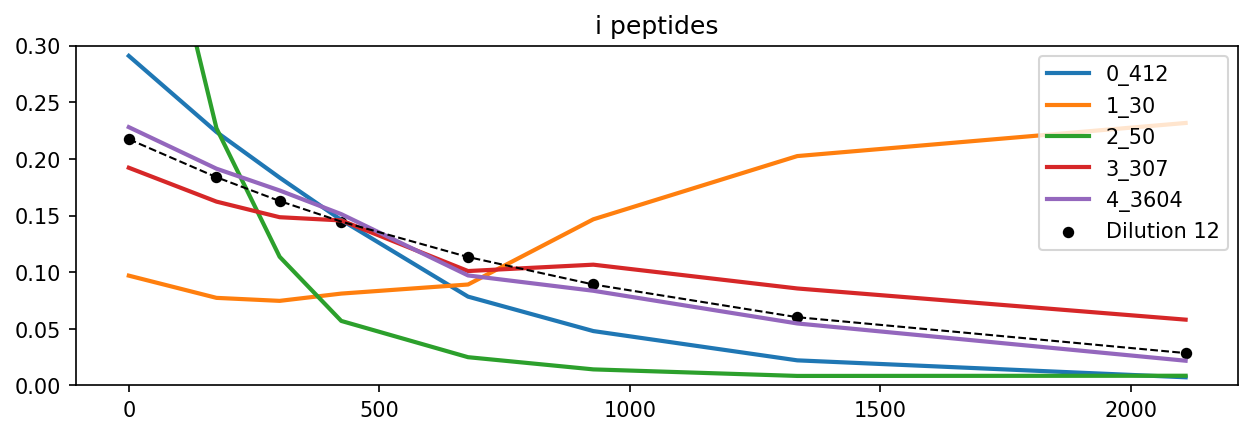

In [9]:
plt.figure(figsize=(10,3),dpi=150)
choice_value='i'

temporary=sub_cellular(choice_value, df_final2)

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']]
no_clusters= 5
kmeans= KMeans(n_clusters=no_clusters, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []

i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    i=i+1


plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution %d'%(nitrogen_test))
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.3])
plt.title('%s peptides'%(choice_value))
plt.legend()
plt.show()

## First iteration for selecting membrane peptides to normalize. 

C:\Users\gupta\AppData\Local\Temp\ipykernel_588\1221901066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary['kmeans_labels']= kmeans.labels_


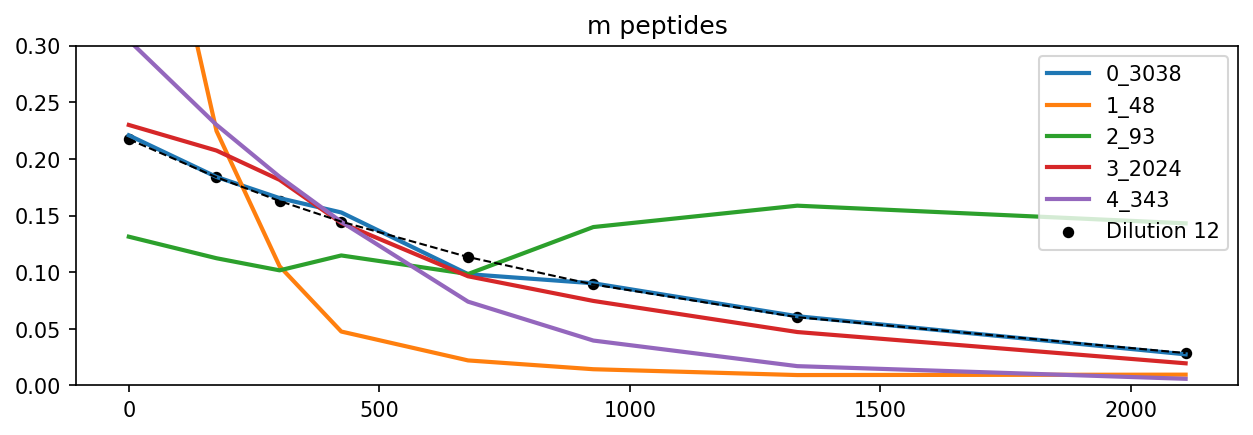

In [10]:
plt.figure(figsize=(10,3),dpi=150)
choice_value=choice_value_input

temporary=sub_cellular(choice_value, df_final2)

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']]
no_clusters= 5
kmeans= KMeans(n_clusters=no_clusters, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []
cosine_distance=[]
i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    cluster_number.append(len(kmeans.labels_[kmeans.labels_==i]))
    cosine_distance.append(cosine_distance_calculator(kmeans.cluster_centers_[i]))
    i=i+1

membrane_peptides_kmeans_clusters=pd.DataFrame({'Labels': np.arange(0,no_clusters), 'cluster_number': cluster_number, 'cosine_distance': cosine_distance})
temporary['kmeans_labels']= kmeans.labels_
membrane_peptides_kmeans= temporary

plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution %d'%(nitrogen_test))
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.3])
plt.title('%s peptides'%(choice_value))
plt.legend()
plt.show()


C:\Users\gupta\AppData\Local\Temp\ipykernel_588\3500461796.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary['cosine_distance']= temporary[med_ave_cols].apply (cosine_distance_calculator, axis=1)


Cluster label that is excluded from normalization 1


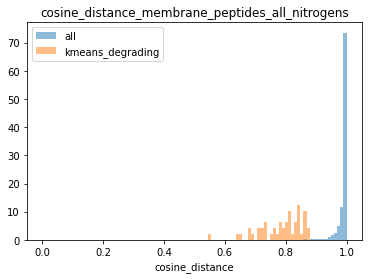

25
All membrane peptides 5546, Membrane_peptides_for_norm 5122


In [11]:
# Asking the cosine distance with a 12 numbered nitrogen

temporary=sub_cellular(choice_value, df_final2)


# All membrane peptides
med_ave_cols= [col for col in temporary.columns if 'med_ave' in col]
temporary['cosine_distance']= temporary[med_ave_cols].apply (cosine_distance_calculator, axis=1)

# Only some membrane peptides with a particular number of nitrogens to test if thse have poor cosine distance due to non matching of the peptides
nitrogen_test1= 20
temp_nitrogen_test= temporary[temporary['Nitrogens']==nitrogen_test1]

# Check the peptides that  kmeans_clusters clustering on the membrane proteins pulls out to be the fastest degrading and as a control take all clusters sequentially 
# Check the peptides that  kmeans_clusters clustering on the membrane proteins pulls out to be the fastest degrading and as a control take all clusters sequentially 
cluster_relevant= membrane_peptides_kmeans_clusters[membrane_peptides_kmeans_clusters['cosine_distance']==membrane_peptides_kmeans_clusters['cosine_distance'].min()]
print ('Cluster label that is excluded from normalization %d'%(cluster_relevant['Labels'].values[0]))

degrading_membrane_peptides_kmeans= membrane_peptides_kmeans[membrane_peptides_kmeans['kmeans_labels']==cluster_relevant['Labels'].values[0]]
degrading_membrane_peptides_kmeans1= degrading_membrane_peptides_kmeans[['Peptide', 'ScanF']].merge(temporary, on=['ScanF', 'Peptide'], how='left')


plt.hist(temporary['cosine_distance'], np.linspace(0,1,100),density=True, alpha=0.5, label='all')
# plt.hist(temp_nitrogen_test['cosine_distance'], np.linspace(0,1,100), density=True,alpha=0.5, label='nitrogens %d'%(nitrogen_test1))
plt.hist(degrading_membrane_peptides_kmeans1['cosine_distance'], np.linspace(0,1,100), density=True,alpha=0.5, label='kmeans_degrading')
plt.legend()
plt.title ('cosine_distance_membrane_peptides_all_nitrogens')
plt.xlabel('cosine_distance')
plt.show()


# the graph of a histogram is just a check in general... we are just using kmeans to throw out degrading proteins
# Find the unique genes whose peptides are degrading 
membrane_ids_delete_norm= pd.DataFrame({'Protein ID': degrading_membrane_peptides_kmeans1['Protein ID'].unique()})
print (len(membrane_ids_delete_norm))
membrane_ids_delete_norm.to_csv('membrane_ids_delete_norm_%s.csv' %(filename))


# Dataset of membrane peptides to be used for normalization
membrane_peptides_all=sub_cellular(choice_value, df_final2)
temporary2= membrane_peptides_all.merge(membrane_ids_delete_norm, on=['Protein ID'], 
                   how='left', indicator=True)
membrane_peptides_for_norm= temporary2[temporary2['_merge']=='left_only']
print ('All membrane peptides %d, Membrane_peptides_for_norm %d'%(membrane_peptides_all.shape[0], membrane_peptides_for_norm.shape[0]))

# Normalization using membrane proteins


In [12]:
truncate_nitrogen_min= 10
truncate_nitrogen_max=18 
membrane_nitrogen_counts= membrane_peptides_for_norm.groupby(['Nitrogens']).count().reset_index().rename(columns={'Protein ID': 'counts'})[['Nitrogens', 'counts']]
membrane_peptides_for_norm_truncate_nitrogens= membrane_peptides_for_norm[(membrane_peptides_for_norm['Nitrogens']> truncate_nitrogen_min) & (membrane_peptides_for_norm['Nitrogens']< truncate_nitrogen_max)]
membrane_nitrogen_counts

,Nitrogens,counts
0,8,179
1,9,338
2,10,440
3,11,592
4,12,630
5,13,505
6,14,494
7,15,491
8,16,336
9,17,291


In [13]:
grouped= membrane_peptides_for_norm_truncate_nitrogens[['Nitrogens']+med_ave_cols].groupby(['Nitrogens'])


xvalues=[]

for name, group in grouped:
    xvalues= xvalues+list(normalized_array_for_plotting(Dilution_half_life_hrs,0,int(name)))

yvalues= grouped.median().reset_index().iloc[:,1: ].values.flatten()

# normalizaton 
def func(x, a, b, c, d, e,f,g,h):
    array= np.tile([a,b,c,d,e,f,g,h],len(grouped.groups.keys()))
    return array*x

popt, pcov = curve_fit(func,yvalues, xvalues, p0=[1,1,1,1,1,1,1,1])
popt

array([0.95452398, 0.95352479, 0.95116278, 0.96573028, 1.18031952,
       1.07718376, 1.08757757, 1.24741302])

In [14]:
df_final_normalized= pd.concat([df_final2[['Protein ID', 'Peptide','ScanF', 'Nitrogens','Subcellular location [CC] 1', 'membrane_confirmation']],(df_final2[med_ave_cols]*popt).divide((df_final2[med_ave_cols]*popt).sum(axis=1), axis=0)], axis=1)
df_final_normalized

,Protein ID,Peptide,ScanF,Nitrogens,Subcellular location [CC] 1,membrane_confirmation,0_med_ave,1_med_ave,2_med_ave,3_med_ave,4_med_ave,5_med_ave,6_med_ave,7_med_ave
0,sp|P0ABS1|DKSA_ECOLI,-.MQEGQNR.K,573,13,Cytoplasm,False,0.283244,0.229769,0.186621,0.145932,0.065658,0.054247,0.034455,0.000076
1,sp|P39406|RSMC_ECOLI,R.QMGDNAR.F,616,12,Cytoplasm,False,0.232225,0.212106,0.126223,0.156224,0.085677,0.089967,0.076751,0.020828
2,sp|P39285|MSCM_ECOLI,R.NQLNSQR.Q,787,14,Cell inner membrane,True,0.246521,0.191243,0.160579,0.105290,0.090221,0.092908,0.067747,0.045492
3,sp|P60716|LIPA_ECOLI,R.HHLPVQR.Y,901,15,Cytoplasm.,False,0.463025,0.232980,0.137920,0.087506,0.053101,0.025284,0.000083,0.000101
4,sp|P0A6Z1|HSCA_ECOLI,R.AQDFTTFK.D,10005,10,NaN,False,0.275944,0.220652,0.180294,0.139092,0.094760,0.053261,0.027672,0.008324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30339,sp|P27896|NARQ_ECOLI,R.EAVLNAMK.H,9968,10,Cell inner membrane,True,0.229255,0.176545,0.160399,0.156103,0.102149,0.088943,0.052494,0.034113
30340,sp|P0ABT2|DPS_ECOLI,K.DDDTADILTAASR.D,9970,16,"Cytoplasm, nucleoid.",False,0.323126,0.273397,0.200933,0.141036,0.059014,0.000786,0.000787,0.000921
30341,sp|P00561|AK1H_ECOLI,R.SISVVVNNDDATTGVR.V,9975,21,NaN,False,0.194021,0.180550,0.155747,0.149122,0.128991,0.086209,0.067550,0.037810
30342,sp|P0AFK0|PMBA_ECOLI,R.TVQAALDIAR.Y,9978,14,Cytoplasm.,False,0.184627,0.169134,0.154940,0.108005,0.100907,0.114200,0.096100,0.072087


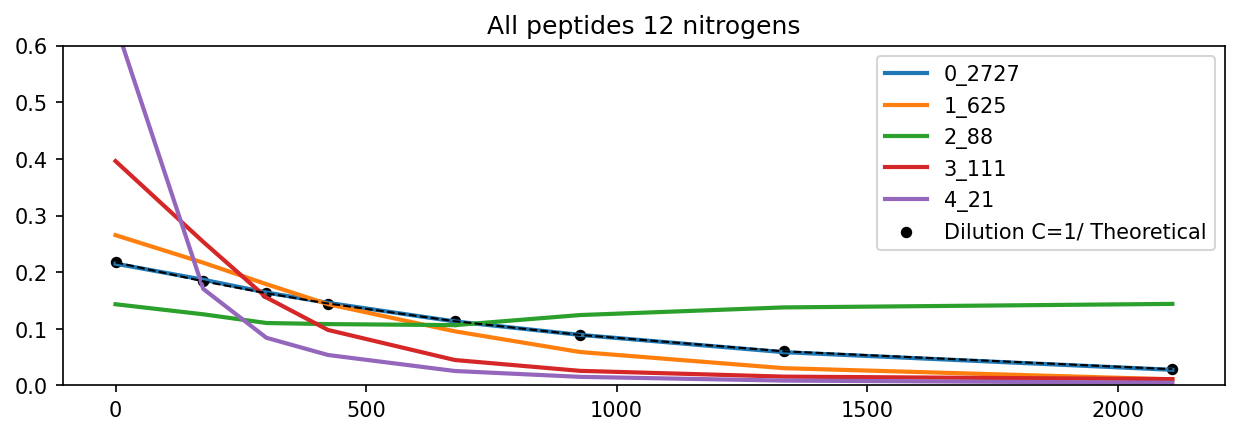

In [15]:
# Check if normalization was actually okay 

plt.figure(figsize=(10,3),dpi=150)

nitrogen_test= 12
temporary=df_final_normalized[df_final_normalized['Nitrogens']==nitrogen_test]

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']]
kmeans= KMeans(n_clusters=5, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []
i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    cluster_number.append(len(kmeans.labels_[kmeans.labels_==i]))
    
    i=i+1
    
plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution C=1/ Theoretical')
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.6])
plt.title('All peptides %d nitrogens'%(nitrogen_test))
plt.legend()
plt.show()


C:\Users\gupta\AppData\Local\Temp\ipykernel_588\1615874720.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary['kmeans_labels']= kmeans.labels_


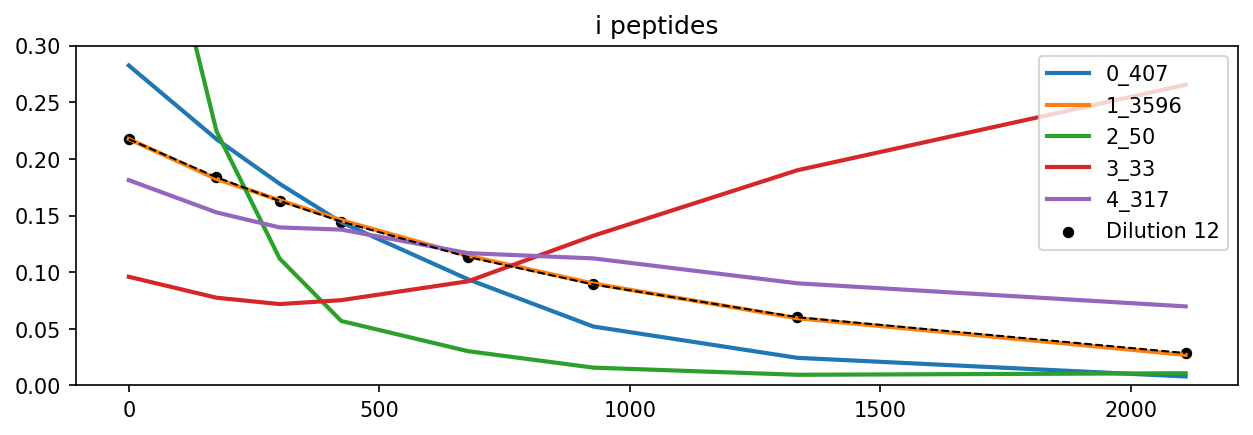

In [16]:
plt.figure(figsize=(10,3),dpi=150)
choice_value='i'

temporary=sub_cellular(choice_value, df_final_normalized)

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']]
no_clusters= 5
kmeans= KMeans(n_clusters=no_clusters, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []
cosine_distance=[]
i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    cluster_number.append(len(kmeans.labels_[kmeans.labels_==i]))
    cosine_distance.append(cosine_distance_calculator(kmeans.cluster_centers_[i]))
    i=i+1

membrane_peptides_kmeans_clusters=pd.DataFrame({'Labels': np.arange(0,no_clusters), 'cluster_number': cluster_number, 'cosine_distance': cosine_distance})
temporary['kmeans_labels']= kmeans.labels_
membrane_peptides_kmeans= temporary

plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution %d'%(nitrogen_test))
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.3])
plt.title('%s peptides'%(choice_value))
plt.legend()
plt.show()

# Fitting the half lives to the curves using the normalized data

In [17]:
# grouped_proteins= df_final_normalized.groupby(['Protein ID'])

# protein_id= []
# half_life=[]

# for name, group in grouped_proteins: 

#     df_temp=grouped_proteins.get_group(name)
#     df_temp1= df_temp[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave','5_med_ave','6_med_ave','7_med_ave']]
#     values1= df_temp1.values.flatten()
#     time_array1= np.tile(time_array, len(df_temp))
#     nitrogens= df_temp['Nitrogens'].values
#     n_array= np.repeat(nitrogens,8)
    
#     protein_id.append(name)

#     try: 
#         array1,array2=curve_fit(degradation, (time_array1, n_array), values1, p0=[np.log(2)/Dilution_half_life_hrs/60])
#         degradation_readjusted_value= array1[0]
#         half_life.append(1*np.log(2)/degradation_readjusted_value/60)
#     except:
#         print (name)
#         half_life.append(float('Nan'))
        
# df_final_proteins= pd.DataFrame({'Protein ID': protein_id, 'Half_life_hrs': half_life})
# df_final_proteins['Entry']= df_final_proteins['Protein ID'].apply(header_splitter)
# df_final_proteins2= df_final_proteins.merge(tmt5_location[['Entry', 'Gene names ','Subcellular location [CC] 1', 'membrane_confirmation']], on='Entry', how='left')
# df_final_proteins2.head()



grouped_proteins= df_final_normalized.groupby(['Protein ID'])

protein_id= []
half_life=[]
pcov= []
sample_size= []

for name, group in grouped_proteins: 

    df_temp=grouped_proteins.get_group(name)
    df_temp1= df_temp[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave','5_med_ave','6_med_ave','7_med_ave']]
    values1= df_temp1.values.flatten()
    time_array1= np.tile(time_array, len(df_temp))
    nitrogens= df_temp['Nitrogens'].values
    n_array= np.repeat(nitrogens,8)
    
    protein_id.append(name)

    try: 
        array1,array2=curve_fit(degradation, (time_array1, n_array), values1, p0=[np.log(2)/Dilution_half_life_hrs/60])
#         print (array2[0][0])
        sample_size.append(len(values1))
        pcov.append(array2[0][0])
        degradation_readjusted_value= array1[0]
        half_life.append(1*np.log(2)/degradation_readjusted_value/60)
    except:
        print (name)
        half_life.append(float('Nan'))
        
        
from scipy.stats.distributions import  t

alpha=0.05

df_final_proteins= pd.DataFrame({'Protein ID': protein_id, 'Half_life_hrs': half_life, 'Cov': pcov, 'sample_size': sample_size})
df_final_proteins['sigma']= df_final_proteins['Cov'].map(lambda x: np.sqrt(x))
df_final_proteins['dof']= df_final_proteins['sample_size'].map(lambda x: x-1 if x>1 else 0)
df_final_proteins['tval']= df_final_proteins['dof'].map(lambda x: t.ppf(1.0-alpha/2., x) )
df_final_proteins['conf_interval_rate_per_min']= df_final_proteins['sigma']*df_final_proteins['tval']


df_final_proteins['Entry']= df_final_proteins['Protein ID'].apply(header_splitter)
df_final_proteins2= df_final_proteins.merge(tmt5_location[['Entry','Gene names ', 'Subcellular location [CC] 1', 'membrane_confirmation']], on='Entry', how='left')
df_final_proteins2.head()

,Protein ID,Half_life_hrs,Cov,sample_size,sigma,dof,tval,conf_interval_rate_per_min,Entry,Gene names,Subcellular location [CC] 1,membrane_confirmation
0,sp|A5A614|YCIZ_ECOLI,6.850883,8.733673e-09,8,0.000093,7,2.364624,0.000221,A5A614,yciZ,NaN,False
1,sp|O32583|THIS_ECOLI,4.692640,8.151765e-08,8,0.000286,7,2.364624,0.000675,O32583,thiS,NaN,False
2,sp|P00350|6PGD_ECOLI,11.629724,1.824642e-10,600,0.000014,599,1.963932,0.000027,P00350,gnd,NaN,False
3,sp|P00363|FRDA_ECOLI,13.693903,9.743500e-10,304,0.000031,303,1.967824,0.000061,P00363,frdA,NaN,False
4,sp|P00370|DHE4_ECOLI,9.902835,1.128412e-09,208,0.000034,207,1.971490,0.000066,P00370,gdhA,NaN,False


In [18]:
df_final_proteins2.to_csv('Half_life_%s.csv'%(filename))

# Get the histograms for half life plots 

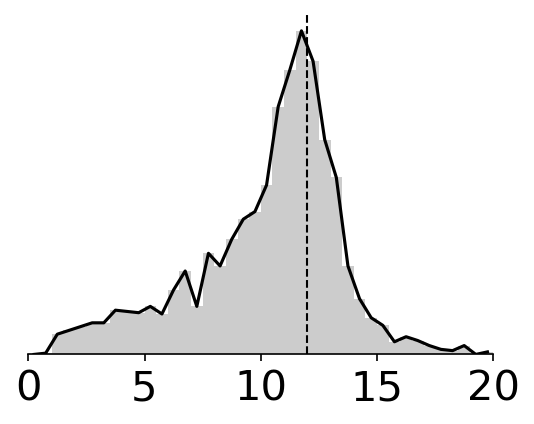

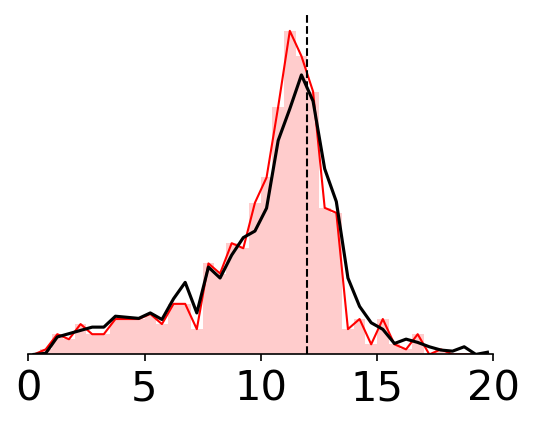

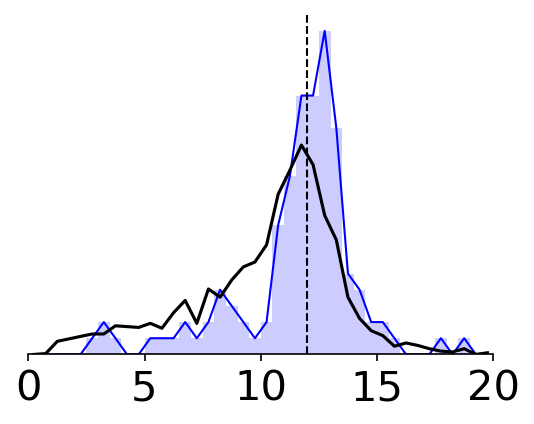

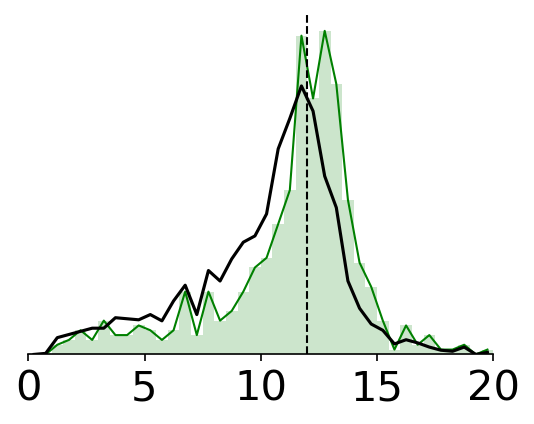

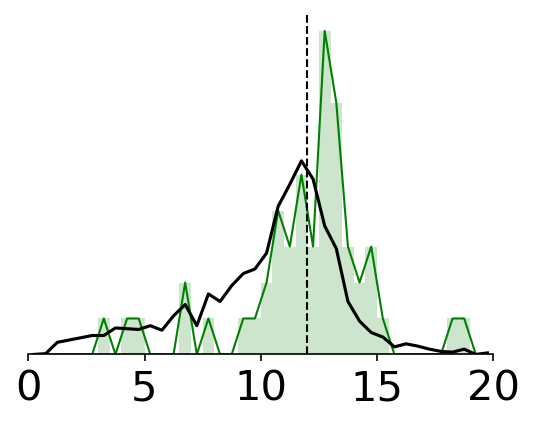

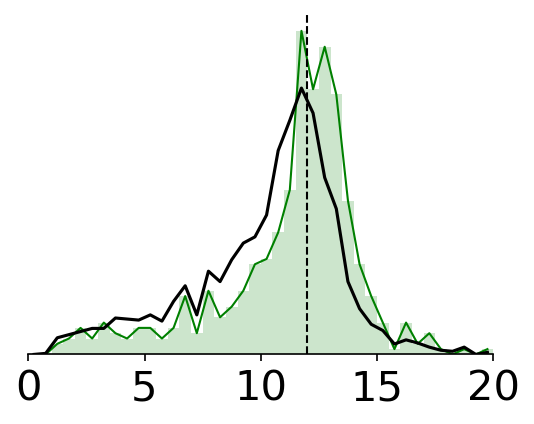

In [19]:
membrane=sub_cellular('m', df_final_proteins2)
cytoplasm= sub_cellular('c', df_final_proteins2)
periplasm= sub_cellular('p', df_final_proteins2)
outer_membrane= sub_cellular('o', df_final_proteins2)
inner_membrane= sub_cellular('i', df_final_proteins2)

vertical_line_p=Dilution_half_life_hrs
alpha_value_shade= 0.2
alpha_value_outline= 1
lw_value_global= 1.5
lw_value_compartments= 1
lw_vertical_line_p= 1
color_global='black' 
color_c= 'red'
color_p= 'blue'
color_m= 'green'
title= '%s'%filename
title_c= 'cytoplasm'
title_m= 'membrane'
title_p= 'periplasm'

plot_value='Half_life_hrs'



bins= np.linspace(0,20,41)
array_bins=[]
i=0
while i< len(bins)-1: 
    array_bins.append((bins[i]+bins[i+1])/2) 
    i=i+1

    
# global     
fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a,b,c=plt.hist(df_final_proteins2['Half_life_hrs'], bins, density=True, color=color_global, alpha= alpha_value_shade)
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,20])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
#plt.savefig('C:\\Users\\mgupta\\Desktop\\Backup\\Research\\Papers\\By me\\Central Dogma\\Data_dump\\rates_hr_%ss.png'%(title))

plt.show()

# cytoplasm_p     
fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(cytoplasm['Half_life_hrs'], bins, density=True, color=color_c, alpha= alpha_value_shade)
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_c, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,20])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
#plt.savefig('C:\\Users\\mgupta\\Desktop\\Backup\\Research\\Papers\\By me\\Central Dogma\\Data_dump\\rates_hr_%ss_%s.png'%(title, title_c))

plt.show()

# cytoplasm_p     
fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(periplasm['Half_life_hrs'], bins, density=True, color=color_p, alpha= alpha_value_shade)
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_p, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,20])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
#plt.savefig('C:\\Users\\mgupta\\Desktop\\Backup\\Research\\Papers\\By me\\Central Dogma\\Data_dump\\rates_hr_%ss_%s.png'%(title, title_p))

plt.show()

# cytoplasm_p     
fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(membrane['Half_life_hrs'], bins, density=True, color=color_m, alpha= alpha_value_shade)
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_m, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,20])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)

fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(outer_membrane['Half_life_hrs'], bins, density=True, color=color_m, alpha= alpha_value_shade)
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_m, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,20])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)

fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(inner_membrane['Half_life_hrs'], bins, density=True, color=color_m, alpha= alpha_value_shade)
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_m, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,20])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
#plt.savefig('C:\\Users\\mgupta\\Desktop\\Backup\\Research\\Papers\\By me\\Central Dogma\\Data_dump\\rates_hr_%ss_%s.png'%(title, title_m))

plt.show()

In [20]:
Dilution_half_life_hrs

12.0